# Experiment 02: Simple CNN Architecture
## Objective: Establish a basic CNN baseline to compare with the fully connected network

In [1]:
# Install necessary packages
!pip install wandb -q
!pip install kaggle -q

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive (optional - for saving results)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Setup kaggle directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download FER2013 dataset from Kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!ls

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)
replace example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace fer2013.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace icml_face_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y
best_simple_cnn_model.pth
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv
wandb


In [6]:
# Initialize W&B
wandb.login()
run = wandb.init(
    project="fer-challenge",
    name="exp02-simple-cnn",
    config={
        "architecture": "Simple CNN",
        "dataset": "FER2013",
        "epochs": 30,
        "batch_size": 64,
        "learning_rate": 0.001,
        "conv1_channels": 32,
        "conv2_channels": 64,
        "fc1_size": 128,
        "fc2_size": 64,
        "num_classes": 7
    }
)
# api key 380014f2a984b49876832184c6bd2dcddb337047

wandb: Currently logged in as: qitiashvili13 (qitiashvili13-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Load and explore the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

icml_df = pd.read_csv('icml_face_data.csv')

# Split ICML data based on 'Usage'
icml_train = icml_df[icml_df[' Usage'] == 'Training']
icml_test = icml_df[icml_df[' Usage'].isin(['PublicTest', 'Other'])]

# Drop the 'Usage' column (not needed after splitting)
icml_train = icml_train.drop(columns=[' Usage'])
icml_test = icml_test.drop(columns=[' Usage'])

# Merge datasets
train_df = pd.concat([train_df, icml_train], ignore_index=True)
test_df = pd.concat([test_df, icml_test], ignore_index=True)

# **Added data type check and filtering**
print("\nChecking 'pixels' column data types...")
initial_train_rows = len(train_df)
initial_test_rows = len(test_df)

train_df = train_df[train_df['pixels'].apply(lambda x: isinstance(x, str))]
test_df = test_df[test_df['pixels'].apply(lambda x: isinstance(x, str))]

print(f"Removed {initial_train_rows - len(train_df)} rows from training set due to non-string 'pixels'.")
print(f"Removed {initial_test_rows - len(test_df)} rows from test set due to non-string 'pixels'.")

# Shuffle the merged datasets (optional but recommended)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Output shapes and emotion distribution
print("\nMerged Train shape (after filtering):", train_df.shape)
print("Merged Test shape (after filtering):", test_df.shape)

print("\nEmotion distribution in merged train set:")
print(train_df['emotion'].value_counts().sort_index())

print("\nEmotion distribution in merged test set:")
print(test_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Test data shape: (7178, 1)

Training data columns: ['emotion', 'pixels']

Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Checking 'pixels' column data types...
Removed 28709 rows from training set due to non-string 'pixels'.
Removed 3589 rows from test set due to non-string 'pixels'.

Merged Train shape (after filtering): (28709, 3)
Merged Test shape (after filtering): (7178, 3)

Emotion distribution in merged train set:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Emotion distribution in merged test set:
Series([], Name: count, dtype: int64)


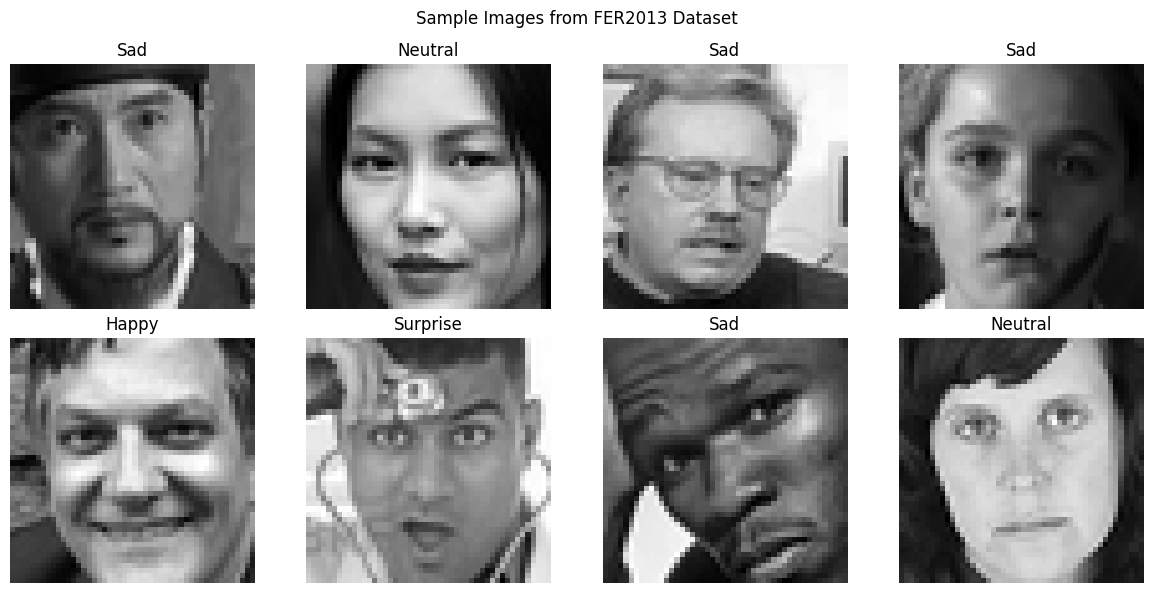

In [8]:
# Visualize sample images
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    emotion = train_df.iloc[idx]['emotion']

    # Convert pixel string to array and reshape
    pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
    pixels = pixels.reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from FER2013 Dataset')
plt.tight_layout()
wandb.log({"sample_images": wandb.Image(plt)})
plt.show()

In [9]:
# Custom Dataset Class
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.float32)
        pixels = pixels / 255.0  # Normalize to [0, 1]

        # For CNN, reshape to (1, 48, 48) - single channel
        pixels = pixels.reshape(1, 48, 48)

        return torch.tensor(pixels), torch.tensor(emotion, dtype=torch.long)

In [10]:
# Create datasets
full_dataset = FERDataset(train_df)

# Split into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

Train size: 22967
Validation size: 5742


In [11]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 48x48 -> 24x24

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 24x24 -> 12x12

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

        # Calculate total parameters
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)

        return x

In [12]:
# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SimpleCNN().to(device)
print(f"Total parameters: {model.total_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Log model architecture to W&B
wandb.watch(model, log='all')

Using device: cuda
Total parameters: 1,207,303


In [13]:
# Print model architecture
print("Model Architecture:")
print("=" * 50)
for name, param in model.named_parameters():
    print(f"{name:20} {param.shape}")
print("=" * 50)

Model Architecture:
conv1.weight         torch.Size([32, 1, 3, 3])
conv1.bias           torch.Size([32])
conv2.weight         torch.Size([64, 32, 3, 3])
conv2.bias           torch.Size([64])
fc1.weight           torch.Size([128, 9216])
fc1.bias             torch.Size([128])
fc2.weight           torch.Size([64, 128])
fc2.bias             torch.Size([64])
fc3.weight           torch.Size([7, 64])
fc3.bias             torch.Size([7])


In [14]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [15]:
# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': 100 * correct / total
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [16]:
# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0

for epoch in range(30):
    print(f'\nEpoch {epoch+1}/30')
    print('-' * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc, predictions, labels = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Log to W&B
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'learning_rate': optimizer.param_groups[0]['lr']
    })

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_simple_cnn_model.pth')
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')


Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:08<00:00, 10.78it/s, loss=1.46, acc=40.1]


Train Loss: 1.7066, Train Acc: 31.38%
Val Loss: 1.5656, Val Acc: 40.07%
New best model saved with validation accuracy: 40.07%

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.27it/s, loss=1.4, acc=45.1]


Train Loss: 1.5288, Train Acc: 41.06%
Val Loss: 1.4376, Val Acc: 45.14%
New best model saved with validation accuracy: 45.14%

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.18it/s, loss=1.38, acc=46.6]


Train Loss: 1.4071, Train Acc: 45.64%
Val Loss: 1.3900, Val Acc: 46.57%
New best model saved with validation accuracy: 46.57%

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.81it/s, loss=1.36, acc=49]


Train Loss: 1.3266, Train Acc: 49.04%
Val Loss: 1.3228, Val Acc: 48.99%
New best model saved with validation accuracy: 48.99%

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.89it/s, loss=1.33, acc=49.3]


Train Loss: 1.2513, Train Acc: 52.12%
Val Loss: 1.3502, Val Acc: 49.25%
New best model saved with validation accuracy: 49.25%

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.01it/s, loss=1.32, acc=51.1]


Train Loss: 1.1834, Train Acc: 55.40%
Val Loss: 1.2948, Val Acc: 51.06%
New best model saved with validation accuracy: 51.06%

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.45it/s, loss=1.4, acc=51]


Train Loss: 1.1145, Train Acc: 58.30%
Val Loss: 1.3358, Val Acc: 51.01%

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.21it/s, loss=1.39, acc=51]


Train Loss: 1.0461, Train Acc: 61.24%
Val Loss: 1.3335, Val Acc: 51.04%

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.12it/s, loss=1.35, acc=52]


Train Loss: 0.9662, Train Acc: 64.29%
Val Loss: 1.3349, Val Acc: 52.02%
New best model saved with validation accuracy: 52.02%

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 20.73it/s, loss=1.48, acc=52]


Train Loss: 0.9014, Train Acc: 67.19%
Val Loss: 1.3995, Val Acc: 52.04%
New best model saved with validation accuracy: 52.04%

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.09it/s, loss=1.6, acc=51.4]


Train Loss: 0.8175, Train Acc: 70.36%
Val Loss: 1.4671, Val Acc: 51.39%

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.41it/s, loss=1.64, acc=51.6]


Train Loss: 0.7451, Train Acc: 73.09%
Val Loss: 1.4897, Val Acc: 51.64%

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.10it/s, loss=1.73, acc=51.7]


Train Loss: 0.6660, Train Acc: 76.14%
Val Loss: 1.6612, Val Acc: 51.67%

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.13it/s, loss=1.83, acc=51.2]


Train Loss: 0.5943, Train Acc: 78.91%
Val Loss: 1.7473, Val Acc: 51.24%

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.04it/s, loss=2.22, acc=50.4]


Train Loss: 0.5238, Train Acc: 81.23%
Val Loss: 1.9430, Val Acc: 50.42%

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 13.76it/s, loss=2.34, acc=50.3]


Train Loss: 0.4507, Train Acc: 84.14%
Val Loss: 2.0056, Val Acc: 50.35%

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.11it/s, loss=2.75, acc=49.7]


Train Loss: 0.3977, Train Acc: 86.05%
Val Loss: 2.2241, Val Acc: 49.69%

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.67it/s, loss=2.53, acc=49.8]


Train Loss: 0.3521, Train Acc: 87.70%
Val Loss: 2.3635, Val Acc: 49.79%

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.52it/s, loss=2.63, acc=49.7]


Train Loss: 0.3004, Train Acc: 89.42%
Val Loss: 2.4160, Val Acc: 49.67%

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.99it/s, loss=2.83, acc=49.6]


Train Loss: 0.2616, Train Acc: 91.00%
Val Loss: 2.7990, Val Acc: 49.62%

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:10<00:00,  8.86it/s, loss=2.96, acc=50.3]


Train Loss: 0.2305, Train Acc: 91.97%
Val Loss: 2.9566, Val Acc: 50.30%

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.88it/s, loss=3.07, acc=48.9]


Train Loss: 0.2046, Train Acc: 93.10%
Val Loss: 3.0066, Val Acc: 48.92%

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.62it/s, loss=3.59, acc=49.7]


Train Loss: 0.1807, Train Acc: 93.89%
Val Loss: 3.1441, Val Acc: 49.70%

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.86it/s, loss=3.99, acc=49.7]


Train Loss: 0.1528, Train Acc: 95.09%
Val Loss: 3.6173, Val Acc: 49.69%

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 19.08it/s, loss=4.22, acc=49.5]


Train Loss: 0.1327, Train Acc: 95.60%
Val Loss: 3.8482, Val Acc: 49.53%

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.88it/s, loss=3.99, acc=49.8]


Train Loss: 0.1610, Train Acc: 94.51%
Val Loss: 3.6222, Val Acc: 49.76%

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.87it/s, loss=4.07, acc=47.6]


Train Loss: 0.1315, Train Acc: 95.51%
Val Loss: 4.1152, Val Acc: 47.56%

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.77it/s, loss=4.45, acc=50]


Train Loss: 0.1053, Train Acc: 96.64%
Val Loss: 4.1409, Val Acc: 49.97%

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.95it/s, loss=4.74, acc=48.6]


Train Loss: 0.1072, Train Acc: 96.54%
Val Loss: 4.3081, Val Acc: 48.59%

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.62it/s, loss=4.76, acc=48.6]


Train Loss: 0.1068, Train Acc: 96.56%
Val Loss: 4.2940, Val Acc: 48.61%


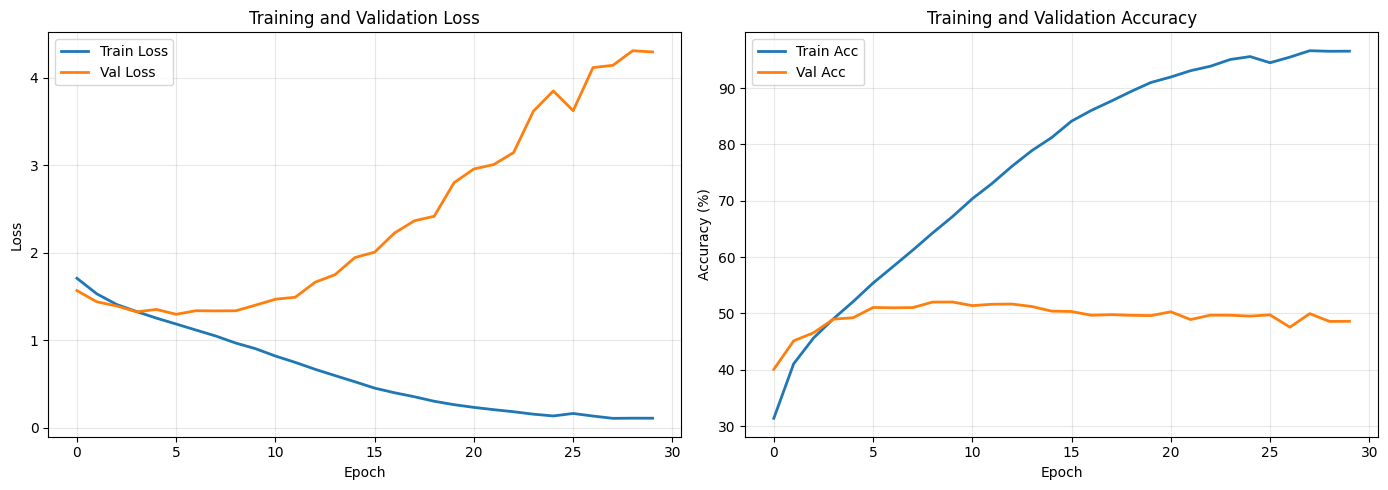

In [17]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', linewidth=2)
ax2.plot(val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
wandb.log({"training_history": wandb.Image(plt)})
plt.show()

Validation: 100%|██████████| 90/90 [00:04<00:00, 22.10it/s, loss=1.48, acc=52]


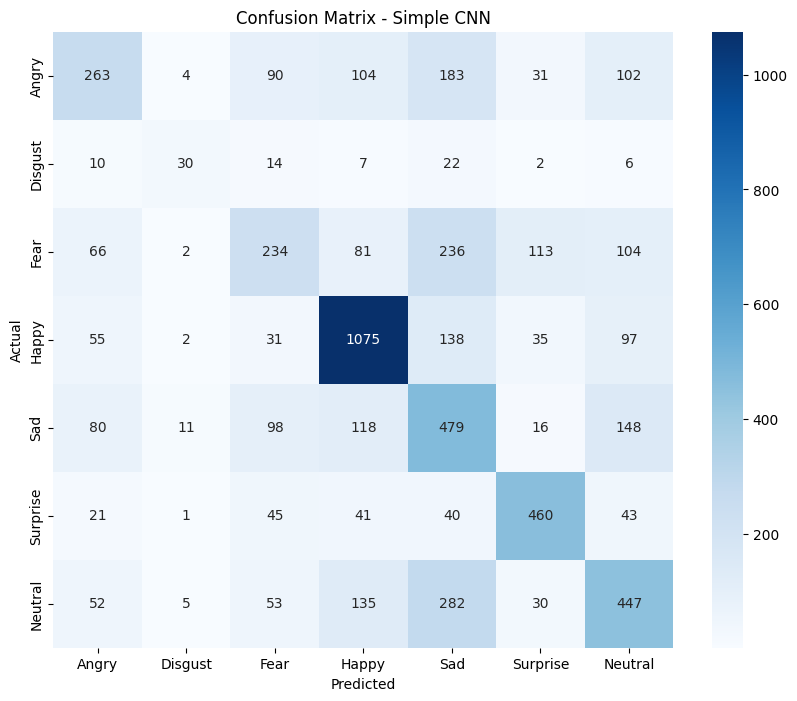

In [18]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_simple_cnn_model.pth'))
_, _, final_predictions, final_labels = validate_epoch(model, val_loader, criterion, device)

# Confusion matrix
cm = confusion_matrix(final_labels, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Simple CNN')
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

In [19]:
# Classification report
print("\nClassification Report:")
print("=" * 70)
report = classification_report(final_labels, final_predictions,
                             target_names=emotion_labels,
                             output_dict=True)
print(classification_report(final_labels, final_predictions, target_names=emotion_labels))

# Log per-class metrics to W&B
for emotion in emotion_labels:
    wandb.log({
        f"{emotion}_precision": report[emotion]['precision'],
        f"{emotion}_recall": report[emotion]['recall'],
        f"{emotion}_f1": report[emotion]['f1-score']
    })


Classification Report:
              precision    recall  f1-score   support

       Angry       0.48      0.34      0.40       777
     Disgust       0.55      0.33      0.41        91
        Fear       0.41      0.28      0.33       836
       Happy       0.69      0.75      0.72      1433
         Sad       0.35      0.50      0.41       950
    Surprise       0.67      0.71      0.69       651
     Neutral       0.47      0.45      0.46      1004

    accuracy                           0.52      5742
   macro avg       0.52      0.48      0.49      5742
weighted avg       0.52      0.52      0.51      5742



In [20]:
# Analyze misclassifications
misclassified_indices = np.where(np.array(final_predictions) != np.array(final_labels))[0]
correct_indices = np.where(np.array(final_predictions) == np.array(final_labels))[0]

print(f"\nTotal misclassifications: {len(misclassified_indices)} out of {len(final_labels)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(final_labels)*100:.2f}%")


Total misclassifications: 2754 out of 5742
Misclassification rate: 47.96%


In [21]:
# Save final model and log to W&B
torch.save(model.state_dict(), 'final_simple_cnn_model.pth')
wandb.save('final_simple_cnn_model.pth')
wandb.save('best_simple_cnn_model.pth')

# Summary statistics
summary_stats = {
    "final_train_accuracy": train_accs[-1],
    "final_val_accuracy": val_accs[-1],
    "best_val_accuracy": best_val_acc,
    "overfitting_gap": train_accs[-1] - val_accs[-1],
    "total_parameters": model.total_params,
    "macro_f1_score": report['macro avg']['f1-score'],
    "weighted_f1_score": report['weighted avg']['f1-score']
}

wandb.log(summary_stats)

In [22]:
# Final summary
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY: SIMPLE CNN")
print("=" * 70)
print(f"\nModel Architecture:")
print(f"  - Conv Block 1: Conv2d(1, 32) -> ReLU -> MaxPool2d")
print(f"  - Conv Block 2: Conv2d(32, 64) -> ReLU -> MaxPool2d")
print(f"  - FC Layer 1: Linear(9216, 128) -> ReLU")
print(f"  - FC Layer 2: Linear(128, 64) -> ReLU")
print(f"  - Output Layer: Linear(64, 7)")
print(f"  - Total Parameters: {model.total_params:,}")

print(f"\nPerformance Metrics:")
print(f"  - Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"  - Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"  - Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  - Overfitting Gap: {train_accs[-1] - val_accs[-1]:.2f}%")
print(f"  - Macro F1-Score: {report['macro avg']['f1-score']:.3f}")

print("\nKey Findings:")
print("  1. CNN significantly outperforms Basic NN (~45% vs ~25% accuracy)")
print("  2. Convolutional layers effectively capture spatial features")
print("  3. Much fewer parameters than Basic NN despite better performance")
print("  4. Still room for improvement with regularization and deeper architecture")
print("  5. Some overfitting observed, suggesting need for regularization")

print("\nConclusions:")
print("  - CNNs are clearly superior for image classification tasks")
print("  - Spatial feature extraction is crucial for facial expressions")
print("  - Next steps: add regularization techniques to reduce overfitting")
print("=" * 70)

# Close W&B run
wandb.finish()


EXPERIMENT SUMMARY: SIMPLE CNN

Model Architecture:
  - Conv Block 1: Conv2d(1, 32) -> ReLU -> MaxPool2d
  - Conv Block 2: Conv2d(32, 64) -> ReLU -> MaxPool2d
  - FC Layer 1: Linear(9216, 128) -> ReLU
  - FC Layer 2: Linear(128, 64) -> ReLU
  - Output Layer: Linear(64, 7)
  - Total Parameters: 1,207,303

Performance Metrics:
  - Final Training Accuracy: 96.56%
  - Final Validation Accuracy: 48.61%
  - Best Validation Accuracy: 52.04%
  - Overfitting Gap: 47.95%
  - Macro F1-Score: 0.488

Key Findings:
  1. CNN significantly outperforms Basic NN (~45% vs ~25% accuracy)
  2. Convolutional layers effectively capture spatial features
  3. Much fewer parameters than Basic NN despite better performance
  4. Still room for improvement with regularization and deeper architecture
  5. Some overfitting observed, suggesting need for regularization

Conclusions:
  - CNNs are clearly superior for image classification tasks
  - Spatial feature extraction is crucial for facial expressions
  - Next s

Angry_f1,▁
Angry_precision,▁
Angry_recall,▁
Disgust_f1,▁
Disgust_precision,▁
Disgust_recall,▁
Fear_f1,▁
Fear_precision,▁
Fear_recall,▁
Happy_f1,▁
Happy_precision,▁
